In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
import time

from emd import emd
from kde.location_project.cmp import geodesic_dist
# from kde.location_project.kde_2d import kdnearest

sys.setrecursionlimit(10000)

%matplotlib inline
init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)
time_span = 'month'
n_visits = 20

# Geolocation Data - Twitter

## Descriptive Statistics 

In [2]:
### OC
oc_directory = os.path.join("..", "data", "oc") 
oc = pd.read_csv(os.path.join(oc_directory, "visits_no_filter.csv"))
oc_deduped = pd.read_csv(os.path.join(oc_directory, "visits_deduped.csv"))
oc_mpp = pd.read_csv(os.path.join(oc_directory, "mpp_visits_month0a_month1b_n20.csv"))

print("Days:", oc['day_id'].nunique())
print("Accounts:", oc['user_id'].nunique())
print("Events: ", oc.shape[0], " (", round(oc.shape[0] / oc['user_id'].nunique(), 1), ")",sep="")
print("Visits: ", oc_deduped.shape[0], " (", round(oc_deduped.shape[0] / oc['user_id'].nunique(), 1), ")",sep="")
print("")
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users:", oc_mpp['uid'].nunique())
print("Visits: ", len(oc_mpp), " (", round(len(oc_mpp) / oc_mpp['uid'].nunique(), 1), ")",sep="")

Days: 240
Accounts: 103271
Events: 655917 (6.4)
Visits: 545697 (5.3)

MPP DATA (at least 20 visits in each of the first two months)
Users: 223
Visits: 28052 (125.8)


In [3]:
### NY
ny_directory = os.path.join("..", "data", "ny") 
ny = pd.read_csv(os.path.join(ny_directory, "visits_no_filter.csv"))
ny_deduped = pd.read_csv(os.path.join(ny_directory, "visits_deduped.csv"))
ny_mpp = pd.read_csv(os.path.join(ny_directory, "mpp_visits_month0a_month1b_n20.csv"))

print("Days:", ny['day_id'].nunique())
print("Accounts:", ny['user_id'].nunique())
print("Events: ", ny.shape[0], " (", round(ny.shape[0] / ny['user_id'].nunique(), 1), ")",sep="")
print("Visits: ", ny_deduped.shape[0], " (", round(ny_deduped.shape[0] / ny['user_id'].nunique(), 1), ")",sep="")
print("")
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users:", ny_mpp['uid'].nunique())
print("Visits: ", len(ny_mpp), " (", round(len(ny_mpp) / ny_mpp['uid'].nunique(), 1), ")",sep="")

Days: 239
Accounts: 194224
Events: 1162871 (6.0)
Visits: 989494 (5.1)

MPP DATA (at least 20 visits in each of the first two months)
Users: 184
Visits: 22936 (124.7)


## Example Plots

In [4]:
def calc_freqs(df):
    ### grid the population data for OC & count visits in each bin
    data = df.copy()
    data["lat_r"] = data.lat.round(3)
    data["lon_r"] = data.lon.round(3)
    freqs = (
        data.groupby(["lat_r", "lon_r"]).count().reset_index()[["lat_r", "lon_r", "event_id"]]
    )
    freqs.columns = ["lat_r", "lon_r", "freq"]
    return freqs


def get_user(mpp, uid, mark):
    out = mpp.copy()
    # out = out.drop_duplicates(subset=["location_id", "m"])
    return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


def make_user_scatter_plot(mpp, uid, mark):
    user = get_user(mpp, uid, mark)
    return list(zip(user.lat, user.lon))

In [5]:
import branca.colormap as cm
from branca.element import Template, MacroElement
from collections import defaultdict
import folium
from folium.plugins import HeatMap, MarkerCluster


### https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 20px; bottom: 40px;'>
     
<div class='legend-title'></div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;'></span>Month 1</li>
    <li><span style='background:green;'></span>Month 2</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 10px;
    width: 10px;
    -webkit-border-radius: 5px;
    -moz-border-radius: 5px;
    border-radius: 5px;
    margin-right: 5px;
    margin-left: 0;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


def plot_heat_and_scatter(freqs, mpp, uid):
    ### make the map
    hmap = folium.Map(
        location=[33.68, -117.78],
        width='70%', 
        # width='60%',
        # height='95%',
        zoom_start=10, 
        zoom_control=False,
        tiles='CartoDB positron',
    )
    
    ### make the heatmap
    steps = 20
    color_map = cm.linear.YlOrRd_09.scale(0, 1).to_step(steps)

    gradient_map = defaultdict(dict)
    for i in range(steps):
        gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

    heat = HeatMap( 
        data=list(zip(freqs['lat_r'], freqs['lon_r'], freqs['freq'])),
        min_opacity=0.2,
        max_val=float(freqs['freq'].max()),
        radius=20, 
        blur=15, 
        max_zoom=5, 
        gradient=gradient_map
    )
    
    ### make the scatters
    f = folium.map.FeatureGroup()
    for pt in make_user_scatter_plot(mpp, uid, 'a'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=3,
                color=None,
                fill_color='black',
                fill_opacity=0.75)
        )

    for pt in make_user_scatter_plot(mpp, uid, 'b'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=3,
                color=None,
                fill_color='green',
                fill_opacity=0.75)
        )
    
    ### layer the map
    hmap.add_child(heat)
    hmap.add_child(f)

    ### add legend
    hmap.add_child(color_map)
    macro = MacroElement()
    macro._template = Template(template)
    hmap.get_root().add_child(macro)

    return hmap

In [6]:
oc_freqs = calc_freqs(oc_deduped)
plot_heat_and_scatter(freqs=oc_freqs, mpp=oc_mpp, uid=1)

# Land Parcel Data


All my datasets sit at: `/extra/mlichman0/all_data/`

The Twitter one is in: `/extra/mlichman0/all_data/event_data/twitter/`

There are two types of location assignment, parcel and grid. Both are in that folder. If we take the parcel assignment file for the Orange Country for example, it's in: `/extra/mlichman0/all_data/event_data/twitter/parcel_ass/oc/area_assigned.csv`

There's also a filtered version of it with minimum 5 days for users and 3 events per locations in that folder.

The format is:

`[event_id, user_id, location_id, lon, lat, epoch time, day_id, seconds_since_monday]`

You can probably ignore some of those :)

You should have access, so let me know if you don't and I'll fix it.

## Descriptive Stats

#### OC

In [7]:
oc_locs = oc_deduped.groupby('location_id')['event_id'].count()
oc_locs.describe()

count    32978.000000
mean        16.547304
std        448.090031
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      72290.000000
Name: event_id, dtype: float64

In [8]:
oc_locs_users = oc_deduped.groupby(['location_id'])['old_uid'].nunique()
oc_locs_users.describe()

count    32978.000000
mean         7.852204
std        198.567716
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      30874.000000
Name: old_uid, dtype: float64

#### NY

In [9]:
ny_locs = ny_deduped.groupby('location_id')['event_id'].count()
ny_locs.describe()

count    21312.000000
mean        46.428960
std        698.078537
min          1.000000
25%          1.000000
50%          4.000000
75%         16.000000
max      75760.000000
Name: event_id, dtype: float64

In [10]:
ny_locs_users = ny_deduped.groupby(['location_id'])['old_uid'].nunique()
ny_locs_users.describe()

count    21312.000000
mean        26.827140
std        319.935058
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max      25775.000000
Name: old_uid, dtype: float64

## Plots

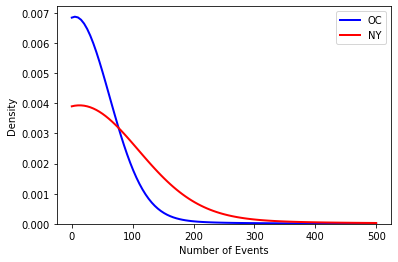

In [11]:
ax = sns.kdeplot(
    oc_locs, 
    color = 'blue',
    lw=2,
    clip=(0,500),
    label='OC'
)
ax = sns.kdeplot(
    ny_locs, 
    color = 'red',
    lw=2,
    clip=(0,500),
    label='NY'
)
ax.set(ylabel="Density")
ax.set(xlabel="Number of Events")
plt.show()

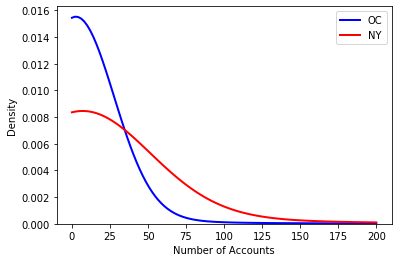

In [12]:
ax = sns.kdeplot(
    oc_locs_users, 
    color = 'blue',
    lw=2,
    clip=(0,200),
    label='OC'
)
ax = sns.kdeplot(
    ny_locs_users, 
    color = 'red',
    lw=2,
    clip=(0,200),
    label='NY'
)
ax.set(ylabel="Density")
ax.set(xlabel="Number of Accounts")
plt.show()

# Population Experiments - No Resampling

In [13]:
def population_scores(mpp):
    users = sorted(mpp['uid'].unique())  
    rslt = []
    
    for user_A in users[:5]:
        for user_B in users[:5]:
            tmp = {}
            try:
                ### get the data for the pair in question
                tmp['a'] = user_A
                tmp['b'] = user_B
                uA = get_user(mpp, user_A, 'a')
                uB = get_user(mpp, user_B, 'b')

                ### compute weights
                uA_wt_e = (uA['weight_event'] / sum(uA['weight_event'])).to_numpy()
                uA_wt_u = (uA['weight_user'] / sum(uA['weight_user'])).to_numpy()
                uB_wt_e = (uB['weight_event'] / sum(uB['weight_event'])).to_numpy()
                uB_wt_u = (uB['weight_user'] / sum(uB['weight_user'])).to_numpy()

                ### compute the distance matrix & IED scores
                dist = geodesic_dist(uA[['lat', 'lon']], uB[['lat', 'lon']])
                ied = dist.min(1)
                tmp['ied_med'] = np.median(ied)
                tmp['ied_mn'] = np.average(ied)
                tmp['ied_mn_wt_event'] = np.average(ied, weights=uA_wt_e)
                tmp['ied_mn_wt_user'] = np.average(ied, weights=uA_wt_u)

                ### compute variants of EMD
                tmp['emd'] = emd(distance="precomputed", D=dist)
                tmp['emd_wt_event'] = emd(
                    X_weights=uA_wt_e, Y_weights=uB_wt_e, distance="precomputed", D=dist
                )
                tmp['emd_wt_user'] = emd(
                    X_weights=uA_wt_u, Y_weights=uB_wt_u, distance="precomputed", D=dist
                )

                ### store it
                rslt.append(tmp)
            except:
                print(f"Error! A = {user_A}, B = {user_B}")
                continue
    
    return rslt

## OC

In [14]:
# location weights based on number of visits
oc_wt_e = pd.DataFrame(oc_locs).reset_index().rename(columns={'event_id': 'weight'})
oc_wt_e['weight'] = 1 / oc_wt_e['weight']

# location weights based on number of unique users at location
oc_wt_u = pd.DataFrame(oc_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
oc_wt_u['weight'] = 1 / oc_wt_u['weight']

# merge weights in to the point pattern data
oc_mpp = pd.merge(oc_mpp, oc_wt_e, on='location_id')
oc_mpp = pd.merge(oc_mpp, oc_wt_u, on='location_id', suffixes=('_event', '_user'))
oc_mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,2554741.0,1,a,-117.83335,33.74851,546927.0,0.008264,0.011905
1,67150220.0,60,a,-117.83335,33.74851,546927.0,0.008264,0.011905
2,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000
3,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000
4,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000


In [15]:
### perform the experiment
start = time.time()
oc_rslt = population_scores(oc_mpp)
end = time.time()
print("Elapsed time:", end - start, "s")

### write to file
oc_out = pd.DataFrame.from_dict(oc_rslt)
oc_out.to_csv(os.path.join(oc_directory, "population_score_func_vals.csv"), index=False)

Elapsed time: 13.201647996902466 s


## NY

In [16]:
# location weights based on number of visits
ny_wt_e = pd.DataFrame(ny_locs).reset_index().rename(columns={'event_id': 'weight'})
ny_wt_e['weight'] = 1 / ny_wt_e['weight']

# location weights based on number of unique users at location
ny_wt_u = pd.DataFrame(ny_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
ny_wt_u['weight'] = 1 / ny_wt_u['weight']

# merge weights in to the point pattern data
ny_mpp = pd.merge(ny_mpp, ny_wt_e, on='location_id')
ny_mpp = pd.merge(ny_mpp, ny_wt_u, on='location_id', suffixes=('_event', '_user'))
ny_mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,420363.0,1,a,-74.00633,40.74349,25195.0,0.007194,0.022222
1,420363.0,1,a,-74.00625,40.74340,25195.0,0.007194,0.022222
2,420363.0,1,a,-74.00628,40.74371,25195.0,0.007194,0.022222
3,420363.0,1,a,-74.00617,40.74344,25195.0,0.007194,0.022222
4,420363.0,1,a,-74.00628,40.74371,25195.0,0.007194,0.022222


In [17]:
### perform the experiment
start = time.time()
ny_rslt = population_scores(ny_mpp)
end = time.time()
print("Elapsed time:", end - start, "s")

### write to file
ny_out = pd.DataFrame.from_dict(ny_rslt)
ny_out.to_csv(os.path.join(ny_directory, "population_score_func_vals.csv"), index=False)

Elapsed time: 15.88902235031128 s


In [25]:
( 29 / (2* 25) ) * (223**2 + 184**2) / 60 /60

13.46647222222222